In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose,LeakyReLU,Dropout

import os
import zipfile
import urllib.request
import random
from IPython import display

import cv2

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        
    # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [10]:
IMAGE_SIZE=64
BATCH_SIZE=32

In [11]:
def get_dataset_slice_paths(image_dir):
    image_file_list = os.listdir(image_dir)
    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

      
    return image_paths


def map_image(image_filename):
    img_raw = tf.io.read_file(image_filename)
      
    image = tf.image.decode_jpeg(img_raw)

    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0  
    image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

    return image

In [12]:
def plot_results(images, n_cols=None):
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [13]:
paths = get_dataset_slice_paths("C:/Users/palash/temp/anime/images")
#paths=get_dataset_slice_paths('C:\\TEMP\\anime')

random.shuffle(paths)


paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
#val_paths = paths[train_paths_len:]


#train_paths[:10000]
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)


# validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
# validation_dataset = validation_dataset.map(map_image)
# validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
#print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 1590


In [14]:
for a in training_dataset:
    print(a.shape[0])
    break

32


In [15]:
random_normal_dimensions=64

generator=tf.keras.models.Sequential([
    
    Dense(8*8*256,input_shape=[random_normal_dimensions]),
    Reshape((8,8,256)),
    BatchNormalization(),
    Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='selu'),
    BatchNormalization(),
    Conv2DTranspose(32,kernel_size=3,strides=2,padding='same',activation='selu'),
    BatchNormalization(),
    Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',activation='tanh')
])

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1064960   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 64)        147520    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        1

In [17]:
discriminator=tf.keras.models.Sequential([
    Conv2D(32,kernel_size=5,strides=2,padding='same',input_shape=[64,64,3]),
    LeakyReLU(alpha=0.2),
    Dropout(0.4),
    Conv2D(64,kernel_size=5,strides=2,padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.4),
    Conv2D(128,kernel_size=5,strides=2,padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.4),
    Flatten(),
    Dense(1,activation='sigmoid')
    
      
])

In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [19]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [20]:
gan = tf.keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy',optimizer='adam')

In [21]:
def train_gan(gan,dataset,random_normal_dimension,n_epochs=50):
    generator,discriminator=gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch+1,n_epochs))
        for real_images in dataset:
            real_batch_size=real_images.shape[0]
            
            noise=tf.random.normal(shape=[real_batch_size,random_normal_dimensions])
            fake_images=generator(noise)
            mixed_images=tf.concat([fake_images,real_images],axis=0)
            discriminator_labels=tf.constant([[0.]] * real_batch_size + [[1.]] * real_batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(mixed_images,discriminator_labels)
            
            noise=tf.random.normal(shape=[real_batch_size,random_normal_dimensions])
            #fake_images=generator(noise)
            ##mixed_images=tf.concat([fake_images,real_images],axis=0)
            generator_labels=tf.constant([[1.]]*real_batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise,generator_labels)
            
        plot_results(fake_images,16)
        plt.show()
        
    return fake_images
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


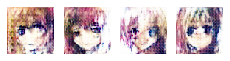

Epoch 11/100


KeyboardInterrupt: 

In [22]:
fake_images = train_gan(gan, training_dataset, random_normal_dimensions, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


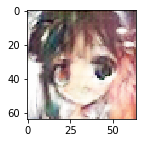

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


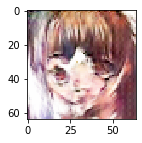

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


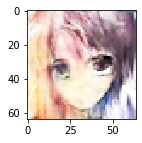

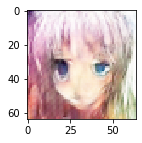

In [16]:
for images in fake_images:
    plt.figure(figsize=(2,2))
    plt.imshow(images)
    plt.show()

In [17]:
noise=tf.random.normal(shape=[1,64])

In [18]:
a=generator(noise)

In [19]:
generator.save('generator.h5')


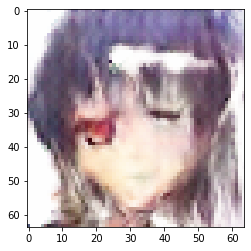

In [20]:
noise=tf.random.normal(shape=[1,64])
a=generator(noise)
a=np.squeeze(a,axis=0)
plt.imshow(a)

In [4]:
from tensorflow.keras.models import load_model


In [5]:
generator=load_model('generator.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


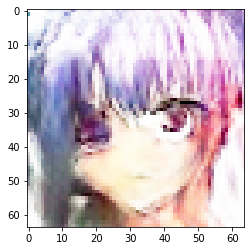

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
noise=tf.random.normal(shape=[1,64])
a=generator(noise)
a=np.squeeze(a,axis=0)
plt.imshow(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

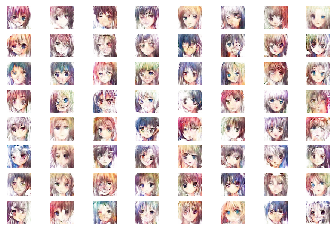

In [7]:
noise=tf.random.normal(shape=[64,64])
results=generator(noise)
INDEX=0
for image in results:
    plt.subplot(8,8,INDEX+1)
    plt.imshow(image)
    plt.axis('off')

    INDEX+=1
    
    